# Ames Housing Price Prediction: Machine Learning Project <a id="top"></a>

[Kaggle Link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

- [Packages & Data Import](#prep)
- [Feature Exploration](#features)
- [Data Cleaning & Missing Values](#cleaning)
- [Feature Engineering](#feature_eng)
- [Preprocessing](#preprocessing)
- [Model Creation](#modeling)
- [Model Comparison](#compare)


## Ideas

Drop imbalanced columns.

Outlier removal

Talk about multi-collinearity

Residuals vs fitted for target varialbe.

Binary features didnt help regression but helped tree.

Convert coefficients to dollars
- e^(mean sale price + coef_estimate) - e^(mean sale price)  / standard dev of x.

supposed to remove 6 points from dataset which are outliers

Code variables as 'able to be influenced vs static'|

Would be great to make a land + house model.

Lots of intangables.
- "you might have heard things like,'paint your rooms yellow to increase the price'.
- Ames only has 1 high school district which would be likely be a strong price predictor. 


[What were kitchen trends 6 years ago?](https://www.google.com/search?q=kitchen+trends+2015&oq=kitchen+trends+2015&aqs=chrome..69i57j0i22i30l3j69i64.5396j0j7&sourceid=chrome&ie=UTF-8)


Preprocessing
https://scikit-learn.org/stable/modules/preprocessing.html

OrdinalEncoding
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder

OneHotEncoding
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder


## Packages <a id='prep'></a>

https://github.com/jupyter/notebook/issues/4980
https://jupyter-notebook.readthedocs.io/en/stable/troubleshooting.html

In [56]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#import missingno


## Data Import

In [94]:
# test and train datasets,
#  Data Description: written description and keys to categorical variables
#  Sample_submission are also included in the kaggle data.
#  
test = pd.DataFrame()
train = pd.DataFrame()
#sample_submission = pd.read_csv("./data/sample_submission.csv")


def custom_import(train_only = False):
    ''' Simple import function to reload data.
    Train_only will return only the Train dataframe
    
    Value:
    If train_only False: tuple of train, test, target
    If train_only True: train dataframe
    '''
    test   = pd.read_csv("./data/test.csv")
    train  = pd.read_csv("./data/train.csv")
    target = train['SalePrice']
    train  = train.drop(labels = ['SalePrice'], axis = 1)

    
    if train_only:
        return train
    else:
        return (train, test, target)

train, test, target = custom_import()

## Feature Exploration <a id='features'></a>

The ames dataset contains 81 features, including an 'ID' and 'Sales Price' (target) column, a mix of categorical and nominal varialbes. Below we describle some of these features using the attached data_description.txt file and consider possible feature engineering.

##### Target Variable

([<matplotlib.axis.XTick at 0x171f93d3940>], [Text(0, 0, '')])

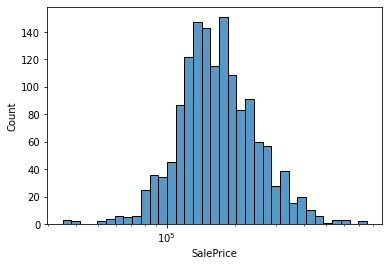

In [80]:
sns.histplot(target,log_scale=True)
#plt.xticks([1000,10000,100000,1000000,10000000])
plt.xticks([100000])

### Eda Plotting and Missingness functions

In [81]:
# Generates a subplot containing all the categorical features
#  numeric features are shunted to jointplot which dont easily support subplots
def eda_plots(cats, nums, data, target, figsize = (20,20), log = False, ylog = True):
    cat_len = len(cats)
    if(cat_len % 2 ==0):
        x = int(cat_len/2)
    else:
        x = int(math.ceil(cat_len/2))
    y = 2
    
    if ylog:
        target = np.log(target)
    else:
        target = target
    
    
    fig, ax = plt.subplots(x,y, figsize = figsize)
    for var, loc in zip(cats,ax.flatten()):
        sns.violinplot(x=data[var], y = target, ax=loc)
        for label in loc.get_xticklabels():
                label.set_rotation(90)
        plt.tight_layout()
    for var in nums:
        if log:
            sns.jointplot(x= np.log(data[var]), y = target, alpha =.1)
        elif not log:
            sns.jointplot(x= data[var], y = target, alpha = .1)
            
            
            
# prints out the column and number of missing values.
def easy_missing(cats, num, data):
    nulls = data[cats+num].isnull().sum(axis =0)
    print("Columns with missing values")
    print(nulls[nulls.values !=0])

### Grouping Features

##### Location Information
- MSZoning: type of zoning
- Street: Type of road access
- Alley: Type of ally access
- Lot Shape: general shape
- LandContour: flatness of property
- LotConfig: how lot relates to street (culdusac, corner, frontage)
- LandSlope: slope, gentle, moderate, severe
- Neighborhood: physical location
- Condition1/2: proximity to conditons (major roads, railroads, parks)


- LotFrontage: linear feet of stread
- LotArea: size in square feet

##### Feature Engineering

- Seems like zoning and neighborhood add a lot to the price
- The spead of lot shape chnages between categories,
- Gravel alleys and Streets have lower log(price) than paved (expected)
- The log of logfrontage and lotArea show a loose correlation with log saleprice.
- Might be worth coding condition1/2 into 9 categorical variables for each condition
- Missingness: Alley: NA = no ally present, might be work recoding into a value ("no_ally")
- missingness: LotFrontage: 

Columns with missing values
Alley          1369
LotFrontage     259
dtype: int64


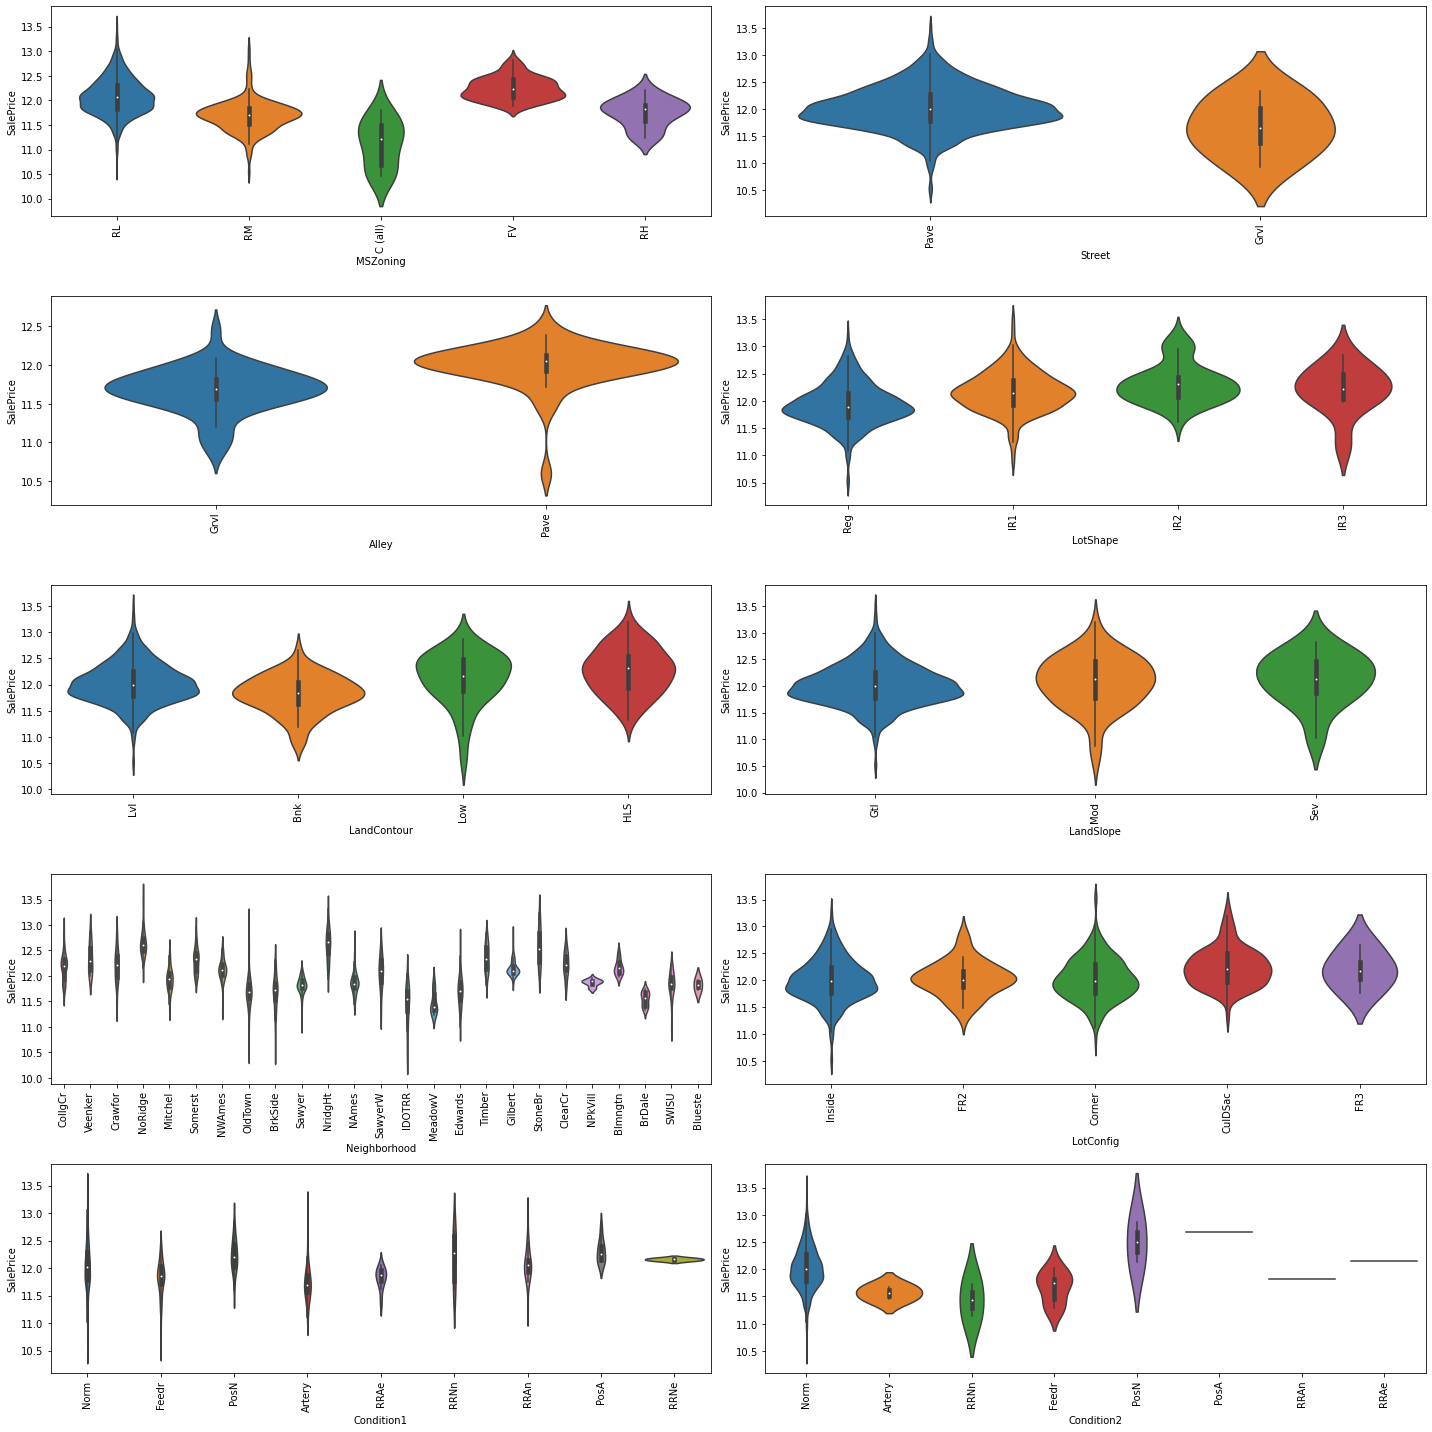

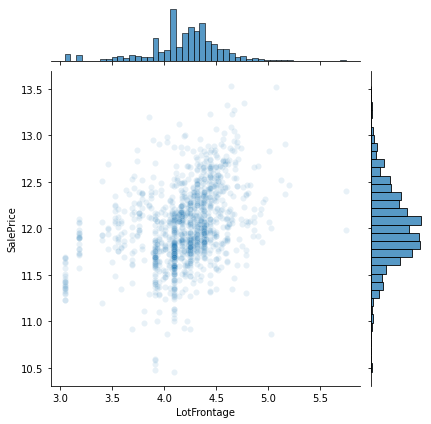

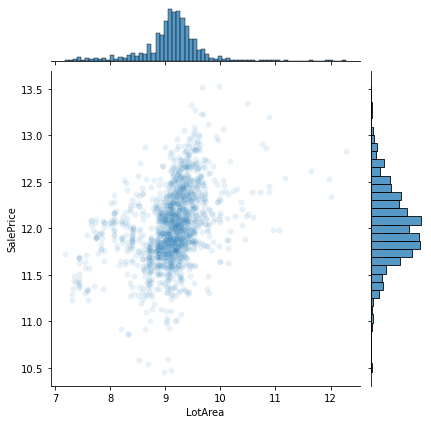

In [65]:
cat_vars = ["MSZoning","Street","Alley","LotShape","LandContour","LandSlope",
            "Neighborhood", "LotConfig",'Condition1','Condition2',]
num_vars = ["LotFrontage","LotArea"]

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,20),
          log = True)

easy_missing(cat_vars, 
             num_vars, 
             train)

##### House (General and Exterior) Information
- MSSubClass: type of dwelling
- BldgType: type of dwelling
- HouseStyle: style of dwelling
- OverallQual: material and finish: numeric but ordinal.
- OverallCond: condition: numeric but ordinal.
- RoofStyle: roof type
- RoofMatl: roof material
- Exterior1st: exterior covering
- Exterior2nd: exterior covering if more than 1
- MasVnrType: masonry veneer type
- ExterQual: material quaility: ordinal
- ExterCond: conditions of materials: ordinal
- Foundation: type

- Utilities: type avalible
- Heating: type
- Heating QC: ordinal
- CentralAir: yes/no
- Electrical: type of electric: ordinal

- YearBuilt: original construction date
- YearRemodAdd: remodel or addition date (same as yearbuilt if no work done)
- MasVnrArea: masonry veneer in sq feet


##### Feature Engineering:
- overall quality explains a good deal of price but needs to be recoded to categorical.
- It seems overall quality explains more than conditon ( overall , exterior)
- Utilities, heading, electrical, and headtingQC all have a condition with only 1 value. might be an outlier?
- YearBuilt and YearRemodeled proabably need to be reconstructed. year_updated or years_since_update?
- MasVnrArea: might be worth exploring a categorical + numeric (MasVnr T/F, MasVnrArea)
- MSSubClass needs to be recoded as a categorical variable same with Quality and Condition.
- Missingness: Vnrtype and Area should be imputted by most common in neighborhood
- Missingness: Electrical, use most common type. 

Columns with missing values
MasVnrType    8
Electrical    1
MasVnrArea    8
dtype: int64


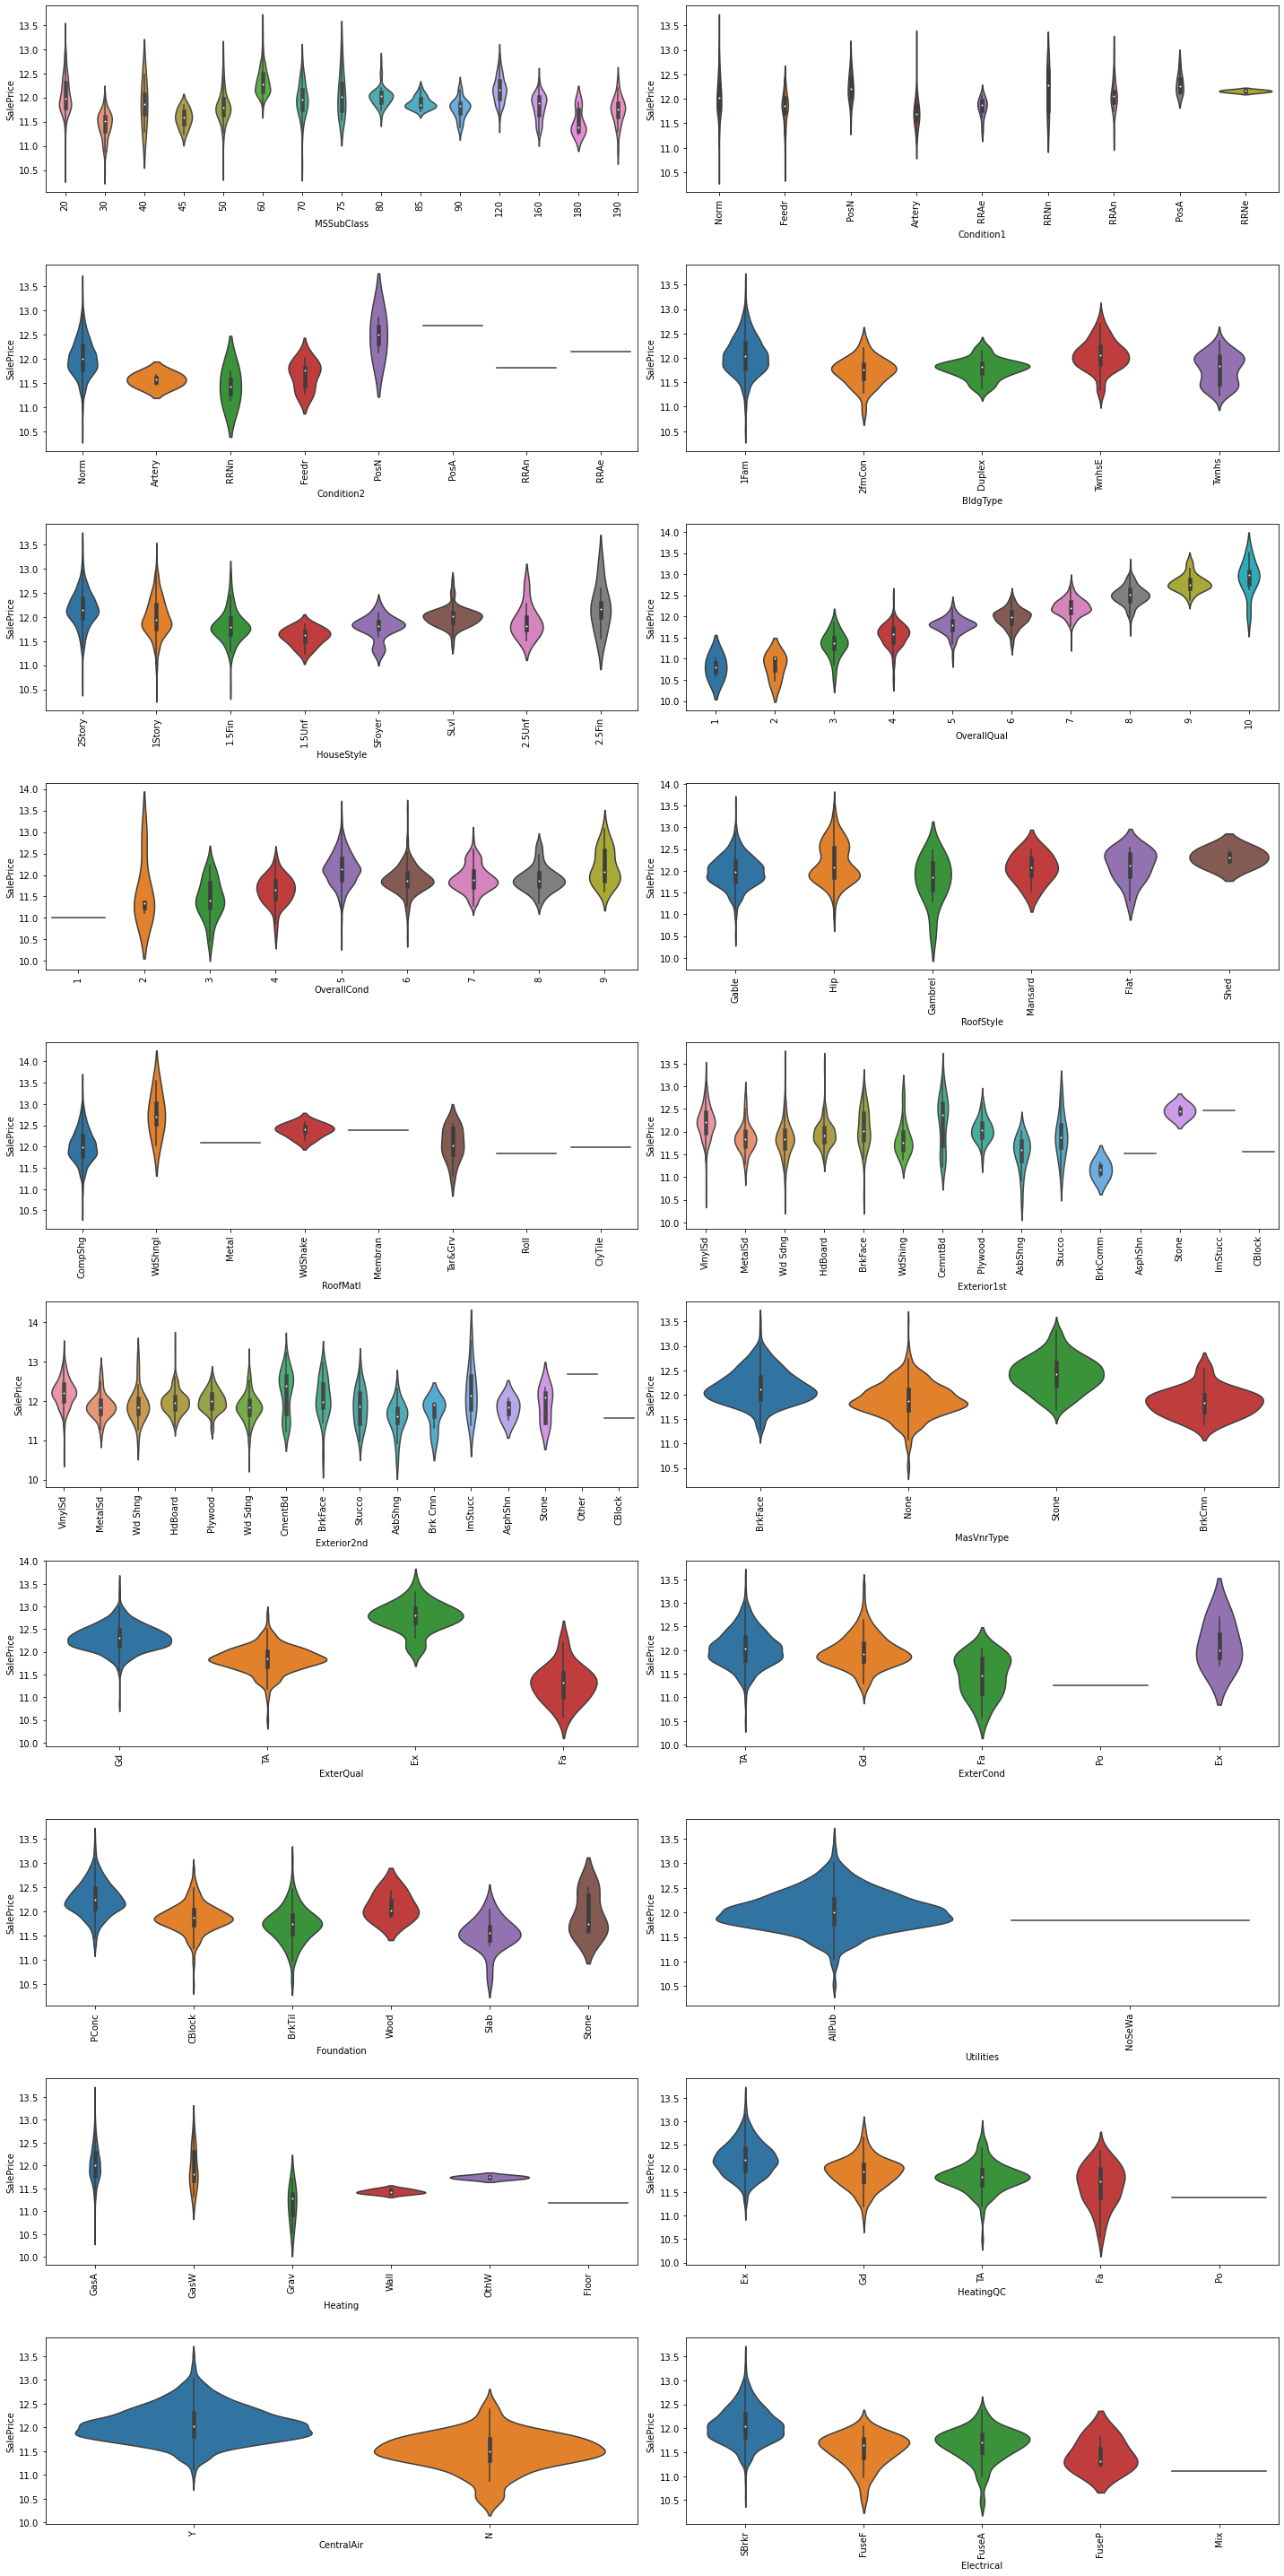

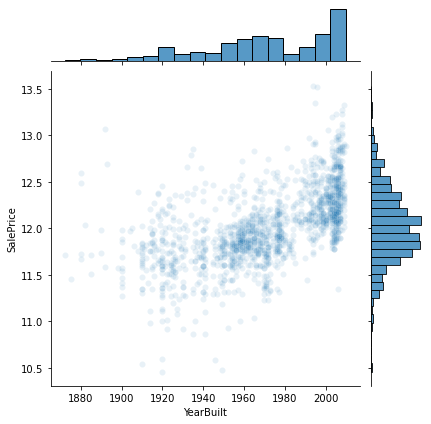

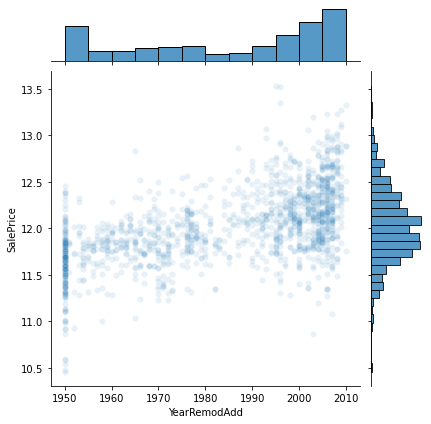

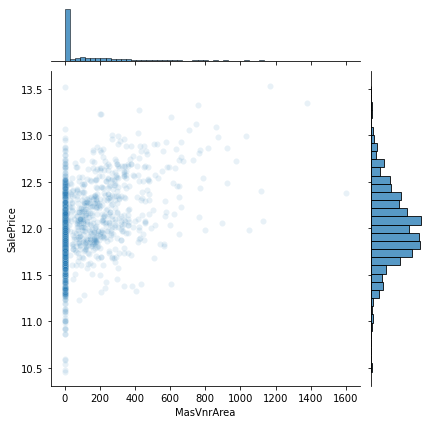

In [19]:
cat_vars = ['MSSubClass','BldgType','HouseStyle','OverallQual','OverallCond',
                'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
                'Utilities','Heating','HeatingQC','CentralAir','Electrical']
num_vars = ['YearBuilt','YearRemodAdd','MasVnrArea']

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,40))

easy_missing(cat_vars, 
             num_vars, 
             train)

##### House (Rooms) Information
- BsmtQual: height of basement: ordinal
- BsmtCond: condition of basement: ordinal
- BsmtExposure: walk out or no outside access
- BsmtFinType1/2: rating of finished area: ordinal
- kitchenQual: kitchen quality: ordinal
- FireplaceQu: fireplace Quality: ordinal

- BsmtFinSF1/2: type 1/2 finished square feet
- BsmtUnfSF: unfinished square feet
- TotalBsmtSF: total basement square feet
- 1stFlrSF: first floor square feet
- 2ndFlrSF: second floor square feet
- LowQualFinSF: low quality finsihed square feet(all floors)
- GrLivArea: above ground living area square feet
- BsmtFullBath: # basement full baths
- BsmtHalfBath: # basement half baths
- FullBath: full baths above ground
- HalfBath: half baths above ground
- Bedroom: bedrooms above ground
- Kitchen: kitchens above ground
- TotRmsAbvGrd: total rooms above grade (not bathrooms)
- Fireplaces: # fireplaces

##### Feature Engineering
- Missingness: All the basement information is likely just mislabeled "no basements"
- Missingness: Fireplace Quality is due to lack of fireplace 
- There doesnt seem to be a big difference between Rec/BLQ/LwQ for BsmtFinType1
- Unfinished Basement SQF doesnt seem to add much
- LowQualFinSF doesnt seem to add anything
- TotalBsmtSF and 1stFlrSF seem to have two groups of distributions.
- Might be worth adding a 'has basement' column
- total_full baths
- total_half baths
- total_baths



Columns with missing values
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
FireplaceQu     690
dtype: int64


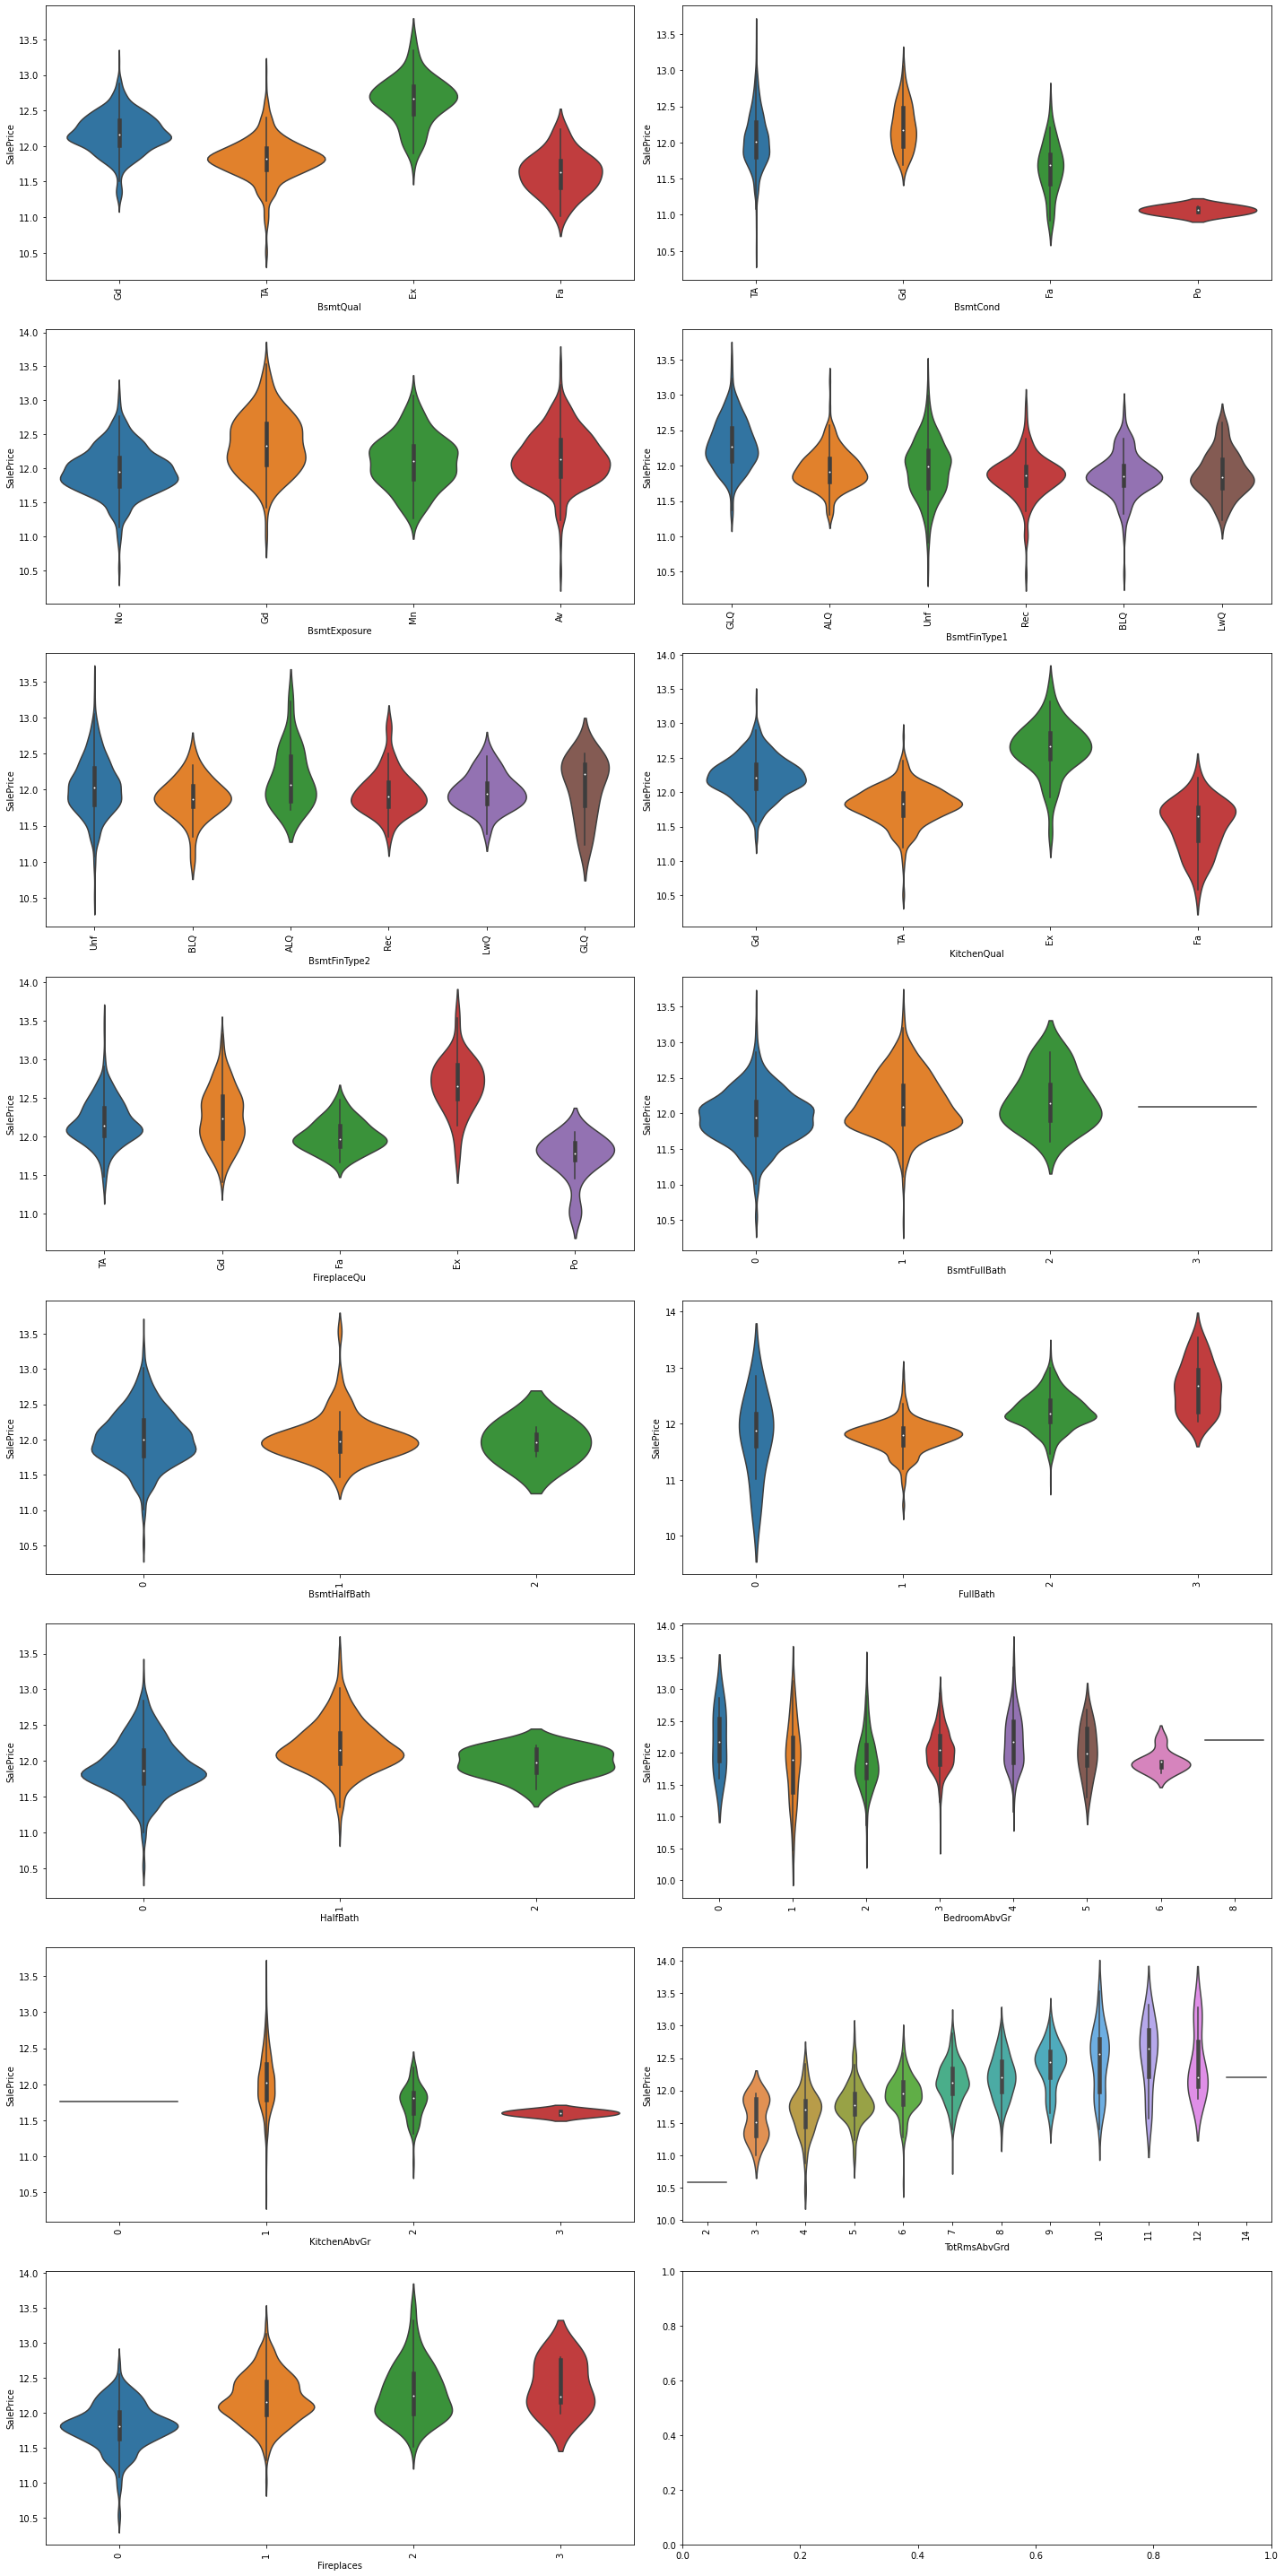

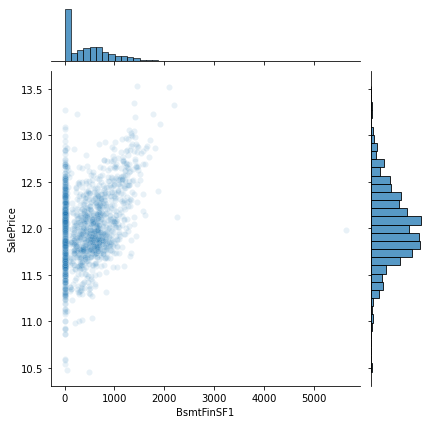

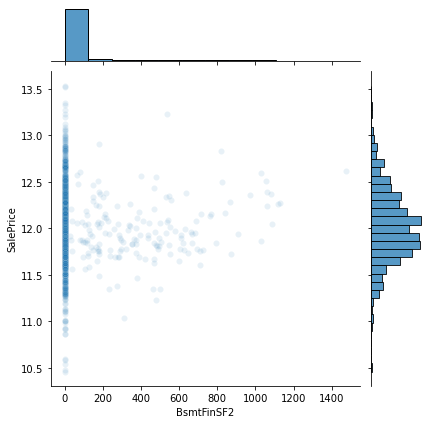

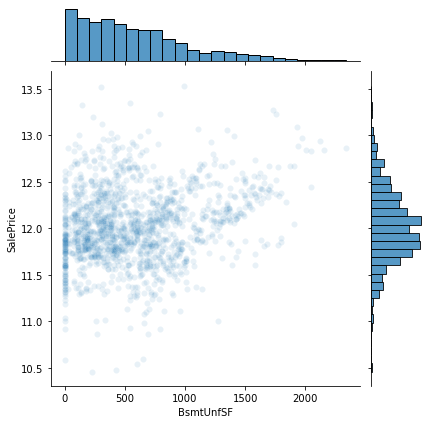

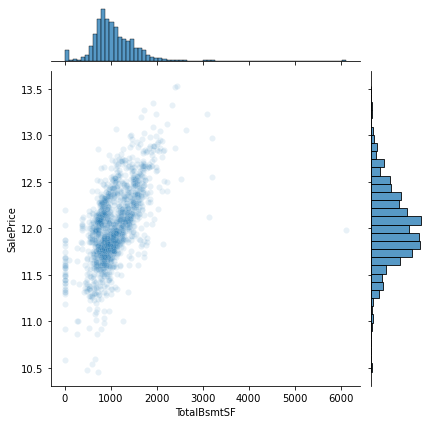

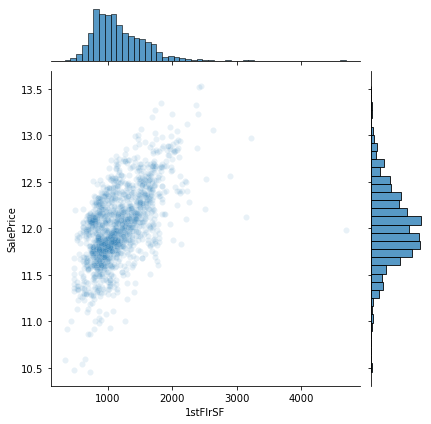

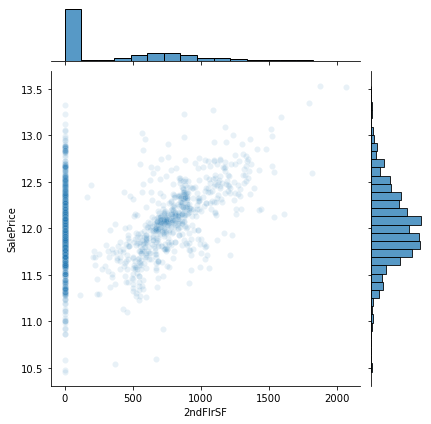

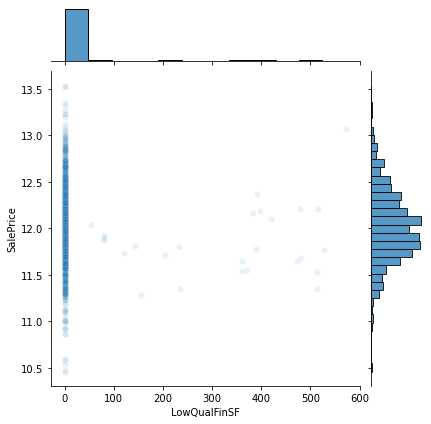

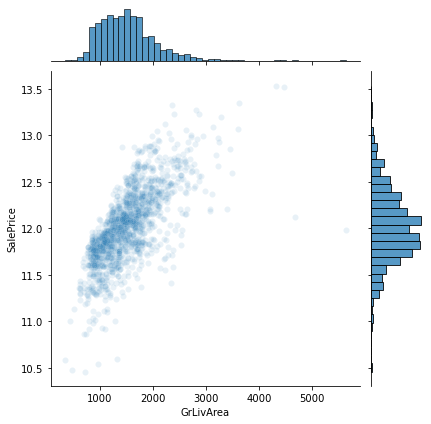

In [22]:
cat_vars = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenQual','FireplaceQu',
            'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces']
num_vars = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea']

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,40))

easy_missing(cat_vars, 
             num_vars, 
             train)

##### Exterior Information
- PoolQC: quality: ordinal
- Fence: quality: (good privacy, good wood, minimum)

- WoodDeckSF: deck square feet
- OpenPorchSF: Open porch  square feet
- EnclosedPorch: square feet
- 3SsnPorch: Three season square feet
- ScreenPorch: Screen  square feet
- PoolArea: Pool square feet

##### Feature Engineering
- Might be able to combine all porches into two features: PorchType, PorchSF. Do houses have more than 1 porch?
- Pool QC seems to add little between Fa/Gd

Columns with missing values
PoolQC    1453
Fence     1179
dtype: int64


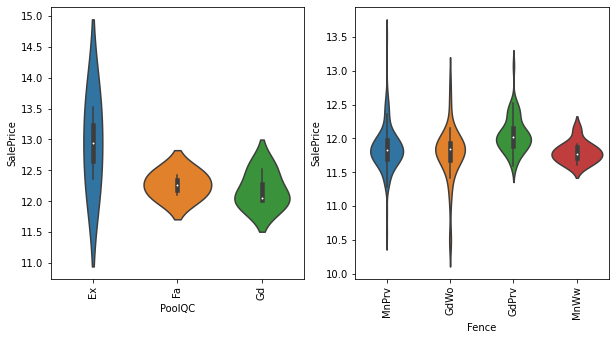

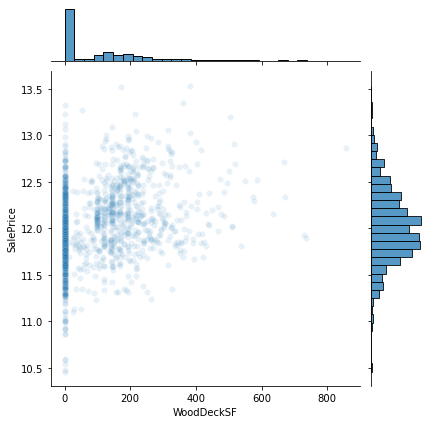

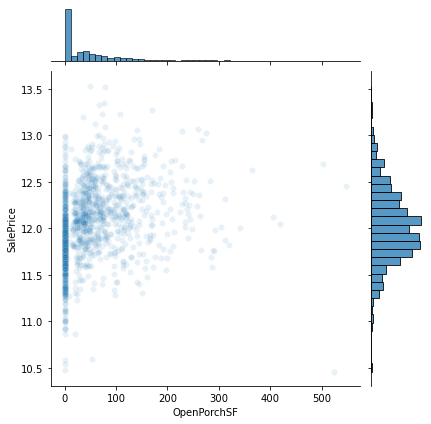

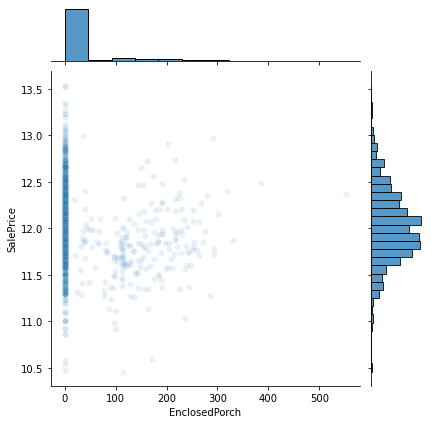

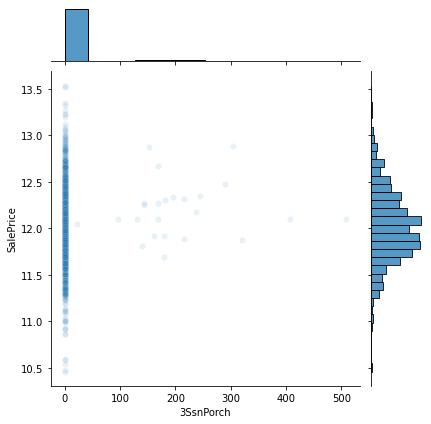

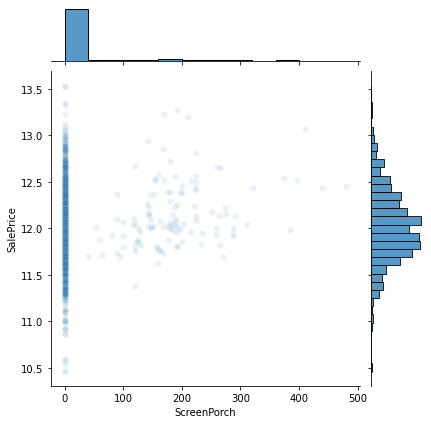

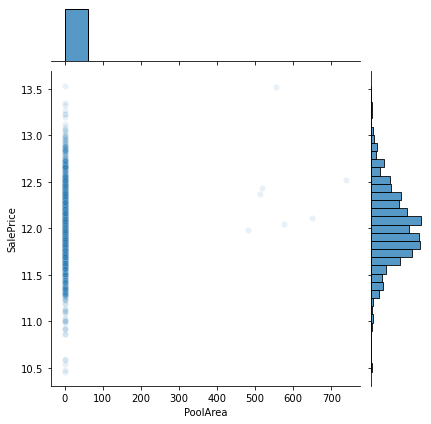

In [16]:
cat_vars = ["PoolQC","Fence"]
num_vars = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea"]

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,20))

easy_missing(cat_vars, 
             num_vars, 
             train)

##### Garage
- GarageType: location (attached, basement, builtin)
- GarageFinish: finish (finished, rough, unfinished, no garage)
- GarageQual: quality: ordinal
- PavedDrive: yes, parital, dirt

- GarageYrBlt: year built
- GarageCars: car capacity
- GarageArea: size in square feet

##### Feature Engineering
- BuiltIn and Attached garages do better as well as finished.
- Supprisingly, excellent quality garages have a very wide distribution
- Garage Area and number of cars are correlated with price (and likely eachother)
- Missingness: Type, finish, year built and quaility are missing because there likely isnt a garage. 

Columns with missing values
GarageType      81
GarageFinish    81
GarageQual      81
GarageYrBlt     81
dtype: int64


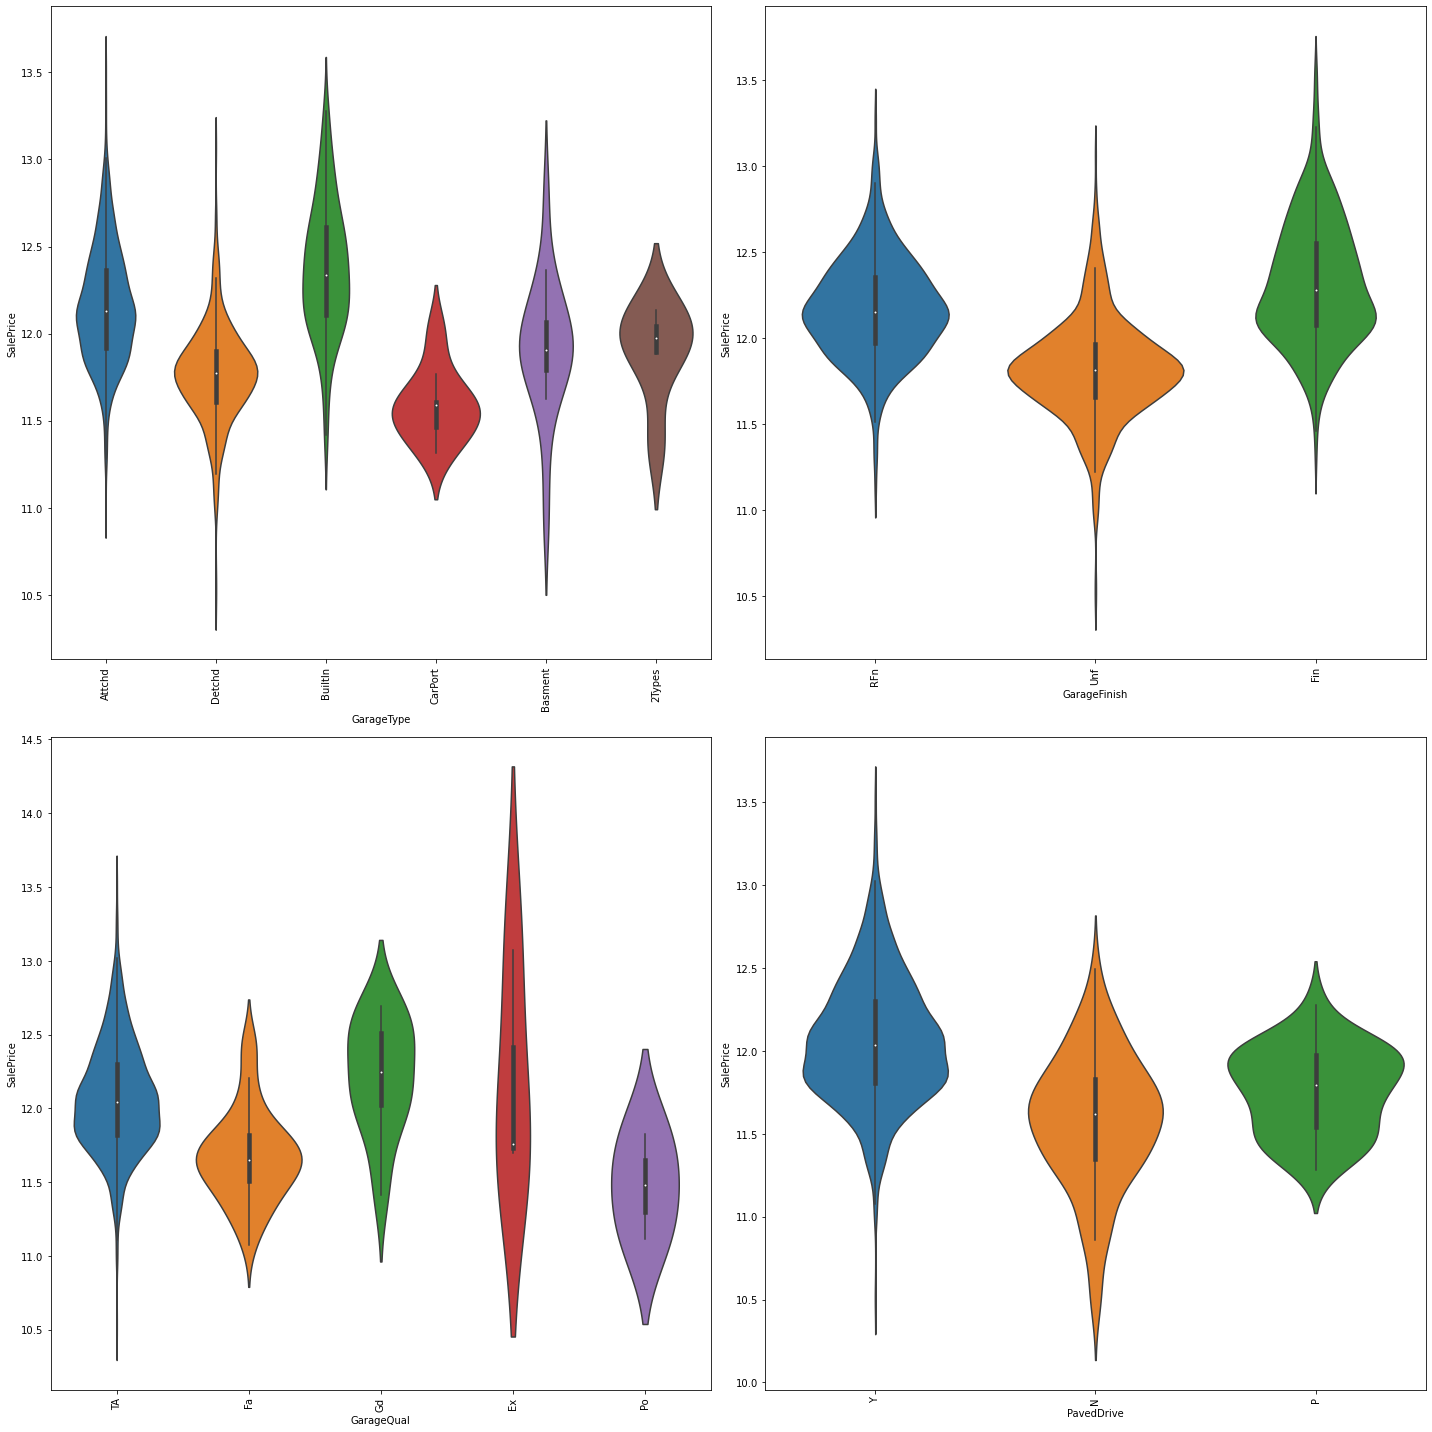

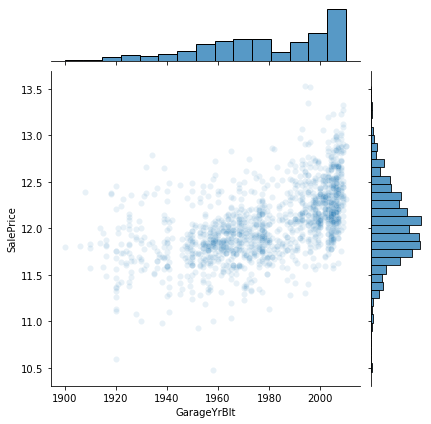

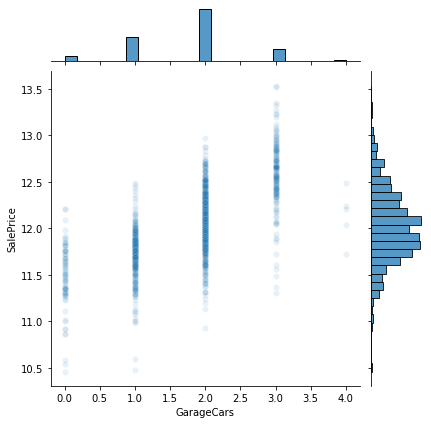

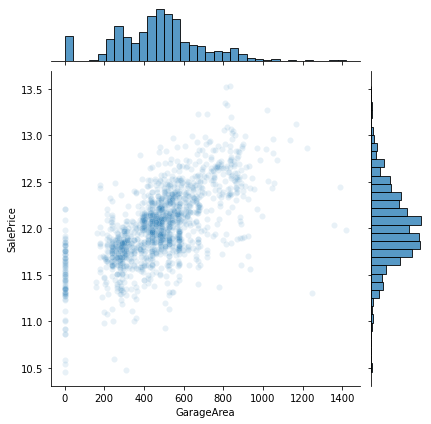

In [23]:
cat_vars = ["GarageType","GarageFinish","GarageQual","PavedDrive"]
num_vars = ["GarageYrBlt","GarageCars","GarageArea"]

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,20))

easy_missing(cat_vars, 
             num_vars, 
             train)

##### Additional Information
- Functional: functionality Typical, minor, major, severe, salvage
- MiscFeature: other features (elevator, shed, tennis court)
- SaleType: type of sale
- SaleCondition: issues with sale (abnormal, adjoining land, family sale, 

- MiscVal: $ value of misc features
- MoSold: month sold
- YrSold: year sold

- ID: Unique identifier
- SalePrice: sale price of houses target variable

##### Additional Information Feature Engineering
- Year and Month sold could obviously be combined. Would be interesting to see if we can see prices rising across these 10 years. Interestingly it also captures the 2009 housing crash. 
- 'Functional' and 'MiscFeature' seem to contain groups with 1 value (Sev and TenC)
- should MiscFeature just be added without coefficents?
- 

Columns with missing values
MiscFeature    1406
dtype: int64


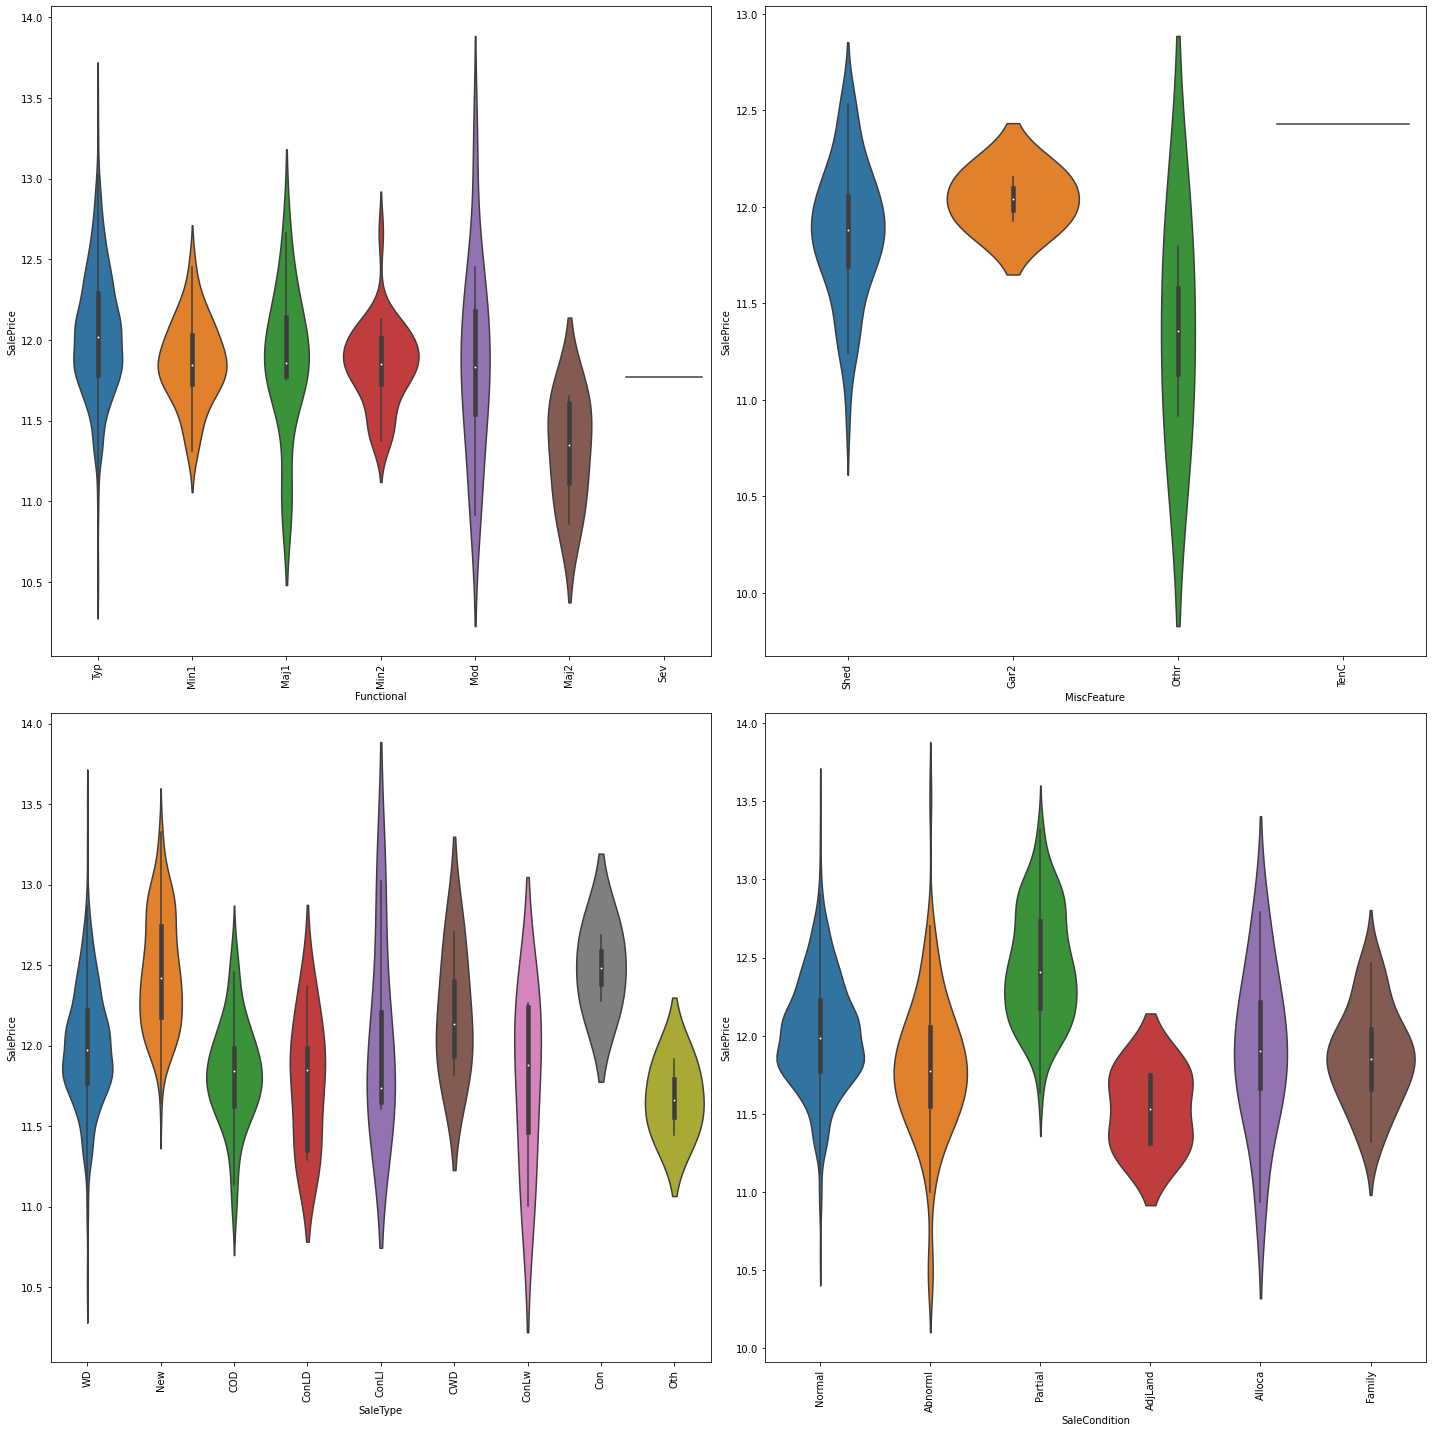

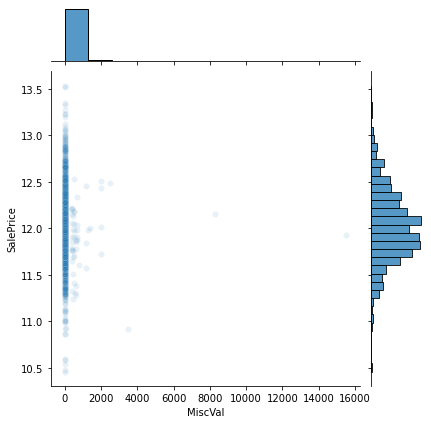

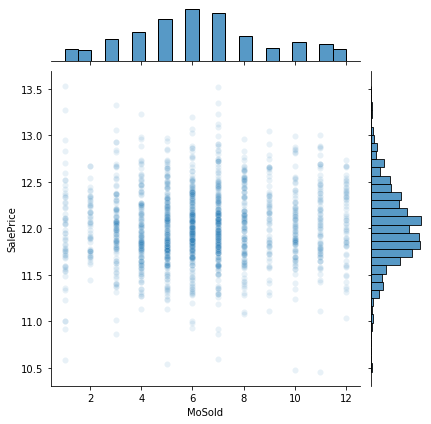

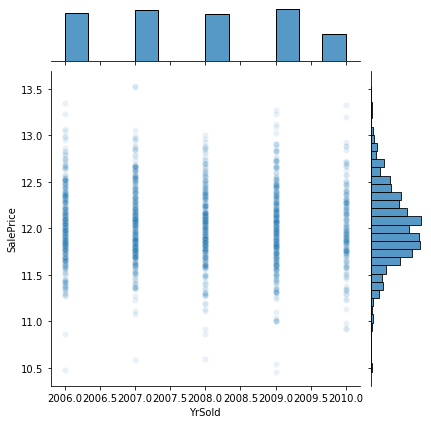

In [25]:
cat_vars = ["Functional","MiscFeature","SaleType","SaleCondition"]
num_vars = ["MiscVal","MoSold","YrSold"]

eda_plots(cats = cat_vars, 
          nums = num_vars, 
          data = train, 
          target = target, 
          figsize=(20,20))

easy_missing(cat_vars, 
             num_vars, 
             train)

## Missing Values & Data Cleaning Function  <a id='cleaning'></a>

[Back to Top](#top)

Text(0.5, 1.0, 'Missing Values by Feature')

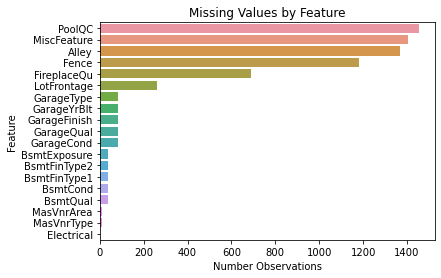

In [12]:
nulls = train.isnull().sum(axis =0)
nulls = nulls[nulls.values !=0].sort_values(ascending=False)
plot  = sns.barplot(x = nulls.values, y = nulls.index, orient='h')
plot.set_ylabel("Feature")
plot.set_xlabel("Number Observations")
plot.set_title("Missing Values by Feature")

In [82]:
def feature_cleaning(data_to_clean):
    ''' Recodes several features, replaces Null values
    as nessesary for a select number of columns.
    Null to "None" and 0 are imputed for most columns. 
    
    Value:
    Returns a dataframe with modified columns. 
    '''
    
    # MSSubClass and ID uses numbers which are read-in as numeric but they are categorical.
    data_to_clean['MSSubClass'] = data_to_clean['MSSubClass'].astype(str)
    

    # imputing with most common
    data_to_clean.Electrical = data_to_clean.Electrical.replace(np.nan, "SBrkr")
    
    # Lot Frontage interpolation by Neighborhood and Lot Config (Cul de sac, inside, corner) mean. 5 values were missed so are filled with neighborhood mean.
    data_to_clean["LotFrontage"] = data_to_clean.groupby(["Neighborhood", "LotConfig"], sort = False)["LotFrontage"].apply(lambda x: x.fillna(x.mean()))
    data_to_clean["LotFrontage"] = data_to_clean.groupby(["Neighborhood"], sort= False)["LotFrontage"].apply(lambda x: x.fillna(x.mean()))
    
    # replacing np.nan to None for missing features (these do not exist in house)
    nan_to_none = ["Alley","MasVnrType","GarageType","GarageFinish","MiscFeature",
                   "PoolQC", "Fence","BsmtQual", "BsmtCond","BsmtExposure","BsmtFinType1",
                   "BsmtFinType2","FireplaceQu", "GarageQual", "GarageCond"]

    data_to_clean[nan_to_none] = data_to_clean[nan_to_none].replace(np.nan, "None")

    # Replacing np.nan in numeric columns with 0
    num_cols = data_to_clean.select_dtypes('number').columns.drop("Id", errors='ignore')
    data_to_clean[num_cols] = data_to_clean[num_cols].replace(np.nan, 0)
    
    
    # Unfortunetly this is all manual but I wanted to keep it togeather.
    # Coercing all columns to stadard rating format Ex,Gd,TA,Fa,Po,None
    non_standard_ordinals = ["BsmtExposure","GarageFinish","Fence"]
    replace_ratings = {"Fence" : {"GdPrv":"Gd","MnPrv":"TA","GdWo":"Fa","MnWw":"Po"},
                       "GarageFinish" : {"Fin":"TA","RFn":"Fa","Unf":"Po"},
                       "BsmtExposure" : {"Av":"TA","Mn":"Fa","No":"Po"}}
    data_to_clean[non_standard_ordinals] = data_to_clean[non_standard_ordinals].replace(replace_ratings)
    
    if data_to_clean.isnull().any().any():
        print("Filling Missing at Random Data")
        for col in data_to_clean.columns[data_to_clean.isnull().any()]:
            data_to_clean[col] = data_to_clean[col].replace(np.nan,data_to_clean[col].mode()[0])            
            
    
    
    return data_to_clean

## Feature Engineering Function <a id='feature_eng'></a>

[Back to Top](#top)

In [84]:
def feature_engineering(data_to_eng, dummify = True):
    '''Feature engineering, dummify is set to True as default,
    this will dummfiy the "Condition1" and "Condition2" columns,
    combining the dummified features (since they are redundant).
    
    Value:
    Returns dataframe, with added columns and recoded columns removed.
    '''
    
    pass
    #Date features
    data_to_eng["YrsSinceBuilt"]    = data_to_eng.YrSold - data_to_eng.YearBuilt
    data_to_eng["Remodeled"]        = data_to_eng.YearBuilt != data_to_eng.YearRemodAdd
    data_to_eng["RecentTaste"]      = (data_to_eng.YrSold - data_to_eng.YearRemodAdd) < 6

    min_garage_yr                   = min(data_to_eng.GarageYrBlt)
    data_to_eng["GarageYrBlt"]      = [0 if pd.isnull(x) else x - min_garage_yr for x in data_to_eng.GarageYrBlt]

    months                          = ["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    data_to_eng["moSold"]           = [months[m] for m in data_to_eng.MoSold]
    
    # Combining 4 porch variables into 2, PorchType and TotalPorchSF. 
    # Excluding WoodDeck because it requires a different permit type.
    porch_vars = ['OpenPorchSF',"EnclosedPorch","3SsnPorch","ScreenPorch"]
    porch_pivot = data_to_eng[porch_vars].astype(bool).replace({'OpenPorchSF':{True:'OpenPorchSF',False:np.nan},
                                            'EnclosedPorch':{True:'EnclosedProch',False:np.nan},
                                            '3SsnPorch':{True:'3SsnPorch',False:np.nan},
                                            'ScreenPorch':{True:'ScreenPorch',False:np.nan}}).apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

    data_to_eng["PorchType"]    = ["NoPorch" if x.split(',')==[""] else "Multiple" if len(x.split(','))>1 else x for x in porch_pivot]
    data_to_eng["TotalPorchSF"] = data_to_eng[porch_vars].sum(axis = 1)
    data_to_eng = data_to_eng.drop(porch_vars, axis=1)

    # pivot features & SF into their own dataframes.
    bsmt1 = data_to_eng.pivot(index = 'Id',columns="BsmtFinType1",values="BsmtFinSF1").replace(np.nan,0)
    bsmt2 = data_to_eng.pivot(index = 'Id',columns="BsmtFinType2",values="BsmtFinSF2").replace(np.nan,0)

    # combine bsmt features and groupby column names, and sum acorss columns (since bsmt1 and 2 have the same features.)
    Bsmt_Feat_SF        = pd.concat([bsmt1,bsmt2],axis=1)
    Bsmt_Feat_SF        = Bsmt_Feat_SF.groupby(Bsmt_Feat_SF.columns, axis=1).sum().reset_index()
    Bsmt_Feat_SF['Unf'] = data_to_eng['BsmtUnfSF']
    data_to_eng         = pd.concat([data_to_eng, Bsmt_Feat_SF],axis=1)
    data_to_eng         = data_to_eng.drop(['BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF'],axis=1)

    # Some Misc Basement Features
    data_to_eng['BsmtFull']    = (data_to_eng['1stFlrSF'] <= data_to_eng.TotalBsmtSF).astype(int)
    data_to_eng['BsmtHQSF']    = Bsmt_Feat_SF[["ALQ","GLQ","Rec"]].sum(axis=1)
    data_to_eng['BsmtPercFin'] = (data_to_eng["BsmtHQSF"] / data_to_eng["TotalBsmtSF"])
    data_to_eng['BsmtMixed']   = data_to_eng[["ALQ","BLQ","GLQ","LwQ","Rec","Unf"]].astype(bool).astype(int).sum(axis=1) >1

    # Some Misc Housing Features.
    data_to_eng['TotalSF']        = data_to_eng[['TotalBsmtSF','1stFlrSF','2ndFlrSF']].sum(axis=1)
    data_to_eng['Floors']         = data_to_eng[['TotalBsmtSF','1stFlrSF','2ndFlrSF']].astype(bool).astype(int).sum(axis=1)
    data_to_eng['TotalBaths']     = data_to_eng[['BsmtFullBath',"BsmtHalfBath","FullBath","HalfBath"]].sum(axis=1)
    data_to_eng['TotalFullBaths'] = data_to_eng[['BsmtFullBath',"FullBath"]].sum(axis=1)
    data_to_eng['TotalHalfBaths'] = data_to_eng[["BsmtHalfBath","HalfBath"]].sum(axis=1)
    data_to_eng['Baths']          = data_to_eng['TotalFullBaths'] + 0.5 * data_to_eng['TotalHalfBaths']
    data_to_eng["HasPool"]        = (data_to_eng['PoolArea'] > 0 ).astype(int)
    data_to_eng["TotalFinSF"]     = data_to_eng['TotalSF'] - data_to_eng['LowQualFinSF']
    
    if dummify:
        # Dummify "Condition1/2" and combine both columns via any().astype()
        road_conds = pd.get_dummies(data_to_eng[["Condition1","Condition2"]], prefix = "Condition", prefix_sep = "_",columns = ["Condition1","Condition2"], dtype=bool)
        road_conds = road_conds.groupby(road_conds.columns, axis = 1).any().astype(int)
        data_to_eng = pd.concat([data_to_eng,road_conds], axis = 1).drop(["Condition1","Condition2"],axis=1)
    
    
    return data_to_eng

# Preprocessing <a id='preprocessing'></a>

[Back to Top](#top)

In [121]:
train, test, target = custom_import()

In [122]:
print("Train Shape and Missingness Before & After Cleaning")
print("Pre: Train Col,Row: {}".format(train.shape))
print("Pre: Missing Values: {}".format(train.isna().sum().sum()))
train = feature_cleaning(train)
print("Post: Train Col,Row: {}".format(train.shape))
print("Post: Missing Values: {}".format(train.isna().sum().sum()))

print("\nTest Shape and Missingness Before & After Cleaning")
print("Pre: Test Col,Row: {}".format(test.shape))
print("Pre: Missing Vlaues: {}".format(test.isna().sum().sum()))
test = feature_cleaning(test)
print("Post: Test Col,Row: {}".format(test.shape))
print("Post: Missing Vlaues: {}".format(test.isna().sum().sum()))

Train Shape and Missingness Before & After Cleaning
Pre: Train Col,Row: (1460, 80)
Pre: Missing Values: 6965
Post: Train Col,Row: (1460, 80)
Post: Missing Values: 0

Test Shape and Missingness Before & After Cleaning
Pre: Test Col,Row: (1459, 80)
Pre: Missing Vlaues: 7000
Filling Missing at Random Data
Post: Test Col,Row: (1459, 80)
Post: Missing Vlaues: 0


In [123]:
print("Train Shape before & after Feature Eng")
print(train.shape)
train = feature_engineering(train)
print(train.shape)

print("\nTest Shape before & after Feature Eng")
print(test.shape)
test = feature_engineering(test)
print(test.shape)


# making a seperate copy for tree-based models
train_unp = train
test_unp  = test

train Shape before & after Feature Eng
(1460, 80)
(1460, 104)
Test Shape before & after Feature Eng
(1459, 80)
(1459, 104)


#### Columns Breakdown

In [124]:
ordinal_cols   = ['ExterQual','ExterCond', 'BsmtQual','BsmtCond', 'BsmtExposure','HeatingQC',
                    'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual','GarageCond', 'PoolQC', 'Fence']

nominal_cols   = train.select_dtypes(include = 'object').columns.drop(ordinal_cols,errors = 'ignore').tolist()

numerical_cols = train.select_dtypes(include = 'number').columns.drop(labels = ["Id"]+ordinal_cols, errors='ignore').tolist()

#### Ordinal Encoding

In [125]:
# Dictionary & ratings for each column
standard_rating_dict = {"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"None":0}
standard_rating = pd.Series(standard_rating_dict).sort_values().index.tolist()
standard_rating = [standard_rating]*len(ordinal_cols)

# Create Ordinal Encoder
Ord_enc = OrdinalEncoder(categories=standard_rating, dtype=np.str_)

# Fit based on the train data, transform both and swap columns. 
train[ordinal_cols] = Ord_enc.fit_transform(train[ordinal_cols])
test[ordinal_cols]  = Ord_enc.transform(test[ordinal_cols])

#### One Hot Encoding

In [126]:
# One Hot Encoder
OH_enc = OneHotEncoder(drop=None, handle_unknown = 'ignore',sparse=False)

# Fit and transform Train, concatenate 
OHE_train = OH_enc.fit_transform(train[nominal_cols])
train     = pd.concat([train, pd.DataFrame(OHE_train, columns = OH_enc.get_feature_names(nominal_cols))],axis=1)
train     = train.drop(nominal_cols,axis=1)

OHE_test = OH_enc.transform(test[nominal_cols])
test     = pd.concat([test, pd.DataFrame(OHE_test, columns = OH_enc.get_feature_names(nominal_cols))],axis=1)
test     = test.drop(nominal_cols,axis=1)



#### Numeric Standardization

In [127]:
# Numeric Standardization
Norm_enc = PowerTransformer(method="yeo-johnson")

# Fit on Train and transform both
train[numerical_cols+ordinal_cols] = Norm_enc.fit_transform(train[numerical_cols+ordinal_cols])
test[numerical_cols+ordinal_cols]  = Norm_enc.transform(test[numerical_cols+ordinal_cols]) 

C:\Users\James\anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


### Unused Homebrewed Ordinal Encoder

In [9]:
#read in categories as keys, target as values, calculate median (mean), get min/max, distribution then normalize 0-1.


def return_order(column, target = None):
    ''' Takes a column of categorical variables,
    returns a list sorted from lowest to highest along the numerical target variable.
    If target is not defined, they will be sorted by frequency.
    Return is sorted lowest (value or frequency) to highest.
    
    Returning by frequency can return a non-obvious order, use with caution.
    '''
    
    if target is not None:
        joined = pd.DataFrame({"cats" : column,"target" : target})
        #joined = joined.groupby('cats').agg({'target':'mean'})
        joined = joined.groupby('cats').agg({'target':'median'})
        #median
        
        return list(joined.sort_values("target",ascending=True).index)
    else:
        pd.Series(column).value_counts()
        return list(pd.Series(column).value_counts(ascending=True).index)

    
    
    
    
ordinal_cols = ['ExterQual','ExterCond', 'BsmtQual','BsmtCond', 'BsmtExposure','HeatingQC',
                'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual','GarageCond', 'PoolQC', 'Fence']

for x in ordinal_cols:
    print(return_order(train[x].replace(np.nan,"None"), target))

# returns non-intuitive answer, might be worth implementing but not as a first pass.

# Modeling Creation <a id='modeling'></a>

[Back to Top](#top)

recursive hyperparam tuning?

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### Prepared Data

**Train**:     Training data, cleaned, with added features, dummification, and standardizaiton 

**Test**:      Test data, cleaned, with added features, dummification, and standardizaiton

**Train_unp**: Training data, cleaned, with added features.

**Test_unp**:  Test data, cleaned, with added features.

Models to examine

Linear
- Ridge & Lasso MLR
- Elastic Net MLR
- SVR

Tree Based
- Regression Random Forest
- Gradient Boost
- XGBoost


In [131]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

In [18]:
# Elastic Net MLR
from sklearn.linear_model import ElasticNet

# Empty Model
elasticnet = ElasticNet()
# Alpha and Rho dimentsions
a_r = (10,10)
# Create alpha & rho ranges, rmse to store 
alpha_space = np.logspace(-10, 2, a_r[0])
rho_space   = np.linspace(0.1, 1, a_r[1])
logs_rmse        = np.zeros(a_r)

dumb_dumb = train[['LotFrontage', "OverallQual","OverallCond","MasVnrArea","1stFlrSF","2ndFlrSF"]]

for alpha in alpha_space:
    for rho in rho_space:
        elasticnet.set_params(alpha = alpha, l1_ratio = rho)
        elasticnet.fit(dumb_dumb, target)
        elasticnet.score(dumb_dumb, target)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [10]:
from itertools import product
def gen_model(model, params_dict):
    
    
    
    
    # pass in the model object
    # save the model object locally
    # pass in the params
    # pass in how many sets/param
    # recursive?
    # find the best model.
    # Pass parameters to pre-processing if needed.
    
    
    
gen_model(model = "hi", params_dict ={"alpha": [0,1,2,3,4], "beta": [1,2,3,4,5]})

[([0, 1, 2, 3, 4],), ([1, 2, 3, 4, 5],)]


# Model Comparison <a id ="compare"></a>